___Name - Arvind Hemant Bondkar___

___PGDPA2101___

___Academic Black Book Project___

# Quora Insincere Questions Classification

## 1. Business/Real-world Problem

### 1.1 Description

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

Credits: Kaggle

__Problem Statement__

- Detect toxic content to improve online conversations.
- We have to develop models that identify and flag insincere questions.
- Source: https://www.kaggle.com/c/quora-insincere-questions-classification

### 1.2 Real world/Business Objectives and Constraints

- The cost of a mis-classification can be very high.
- No strict latency concerns.
- Interpretability is partially important 

## 2. Machine Learning Problem

### 2.1 Data Overview

__General Description__

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

- Has a non-neutral tone
    - Has an exaggerated tone to underscore a point about a group of people
     - Is rhetorical and meant to imply a statement about a group of people
- Is disparaging or inflammatory
    - Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
    - Makes disparaging attacks/insults against a specific person or group of people
    - Based on an outlandish premise about a group of people
    - Disparages against a characteristic that is not fixable and not measurable
- Isn't grounded in reality
    - Based on false information, or contains absurd assumptions
- Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

__File Description__
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - A sample submission in the correct format

__Data fields__
- qid - unique question identifier
- question_text - Quora question text
- target - a question labeled "insincere" has a value of 1, otherwise 0

### 2.2 Mapping the real world problem to an ML problem

#### 2.2.1 Type of Machine Learning Problem
It is a binary classification problem, for a given question we need to predict if it is **insincere** question or not.

#### 2.2.2 Performance Metric

- [F1 Score]

**__Note__:** Some Question Text in Notebook are offensive.

In [ ]:
import numpy as np 
import pandas as pd 
import re 
import string 
import nltk 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams

#### 1)Loading the data and reading the basic stats. 

In [ ]:
# Download Train Dataset
# https://drive.google.com/file/d/1CRUFGCT0NM0SA7l8UvJj-pDamGbeKyYx/view?usp=sharing
! gdown --id 1CRUFGCT0NM0SA7l8UvJj-pDamGbeKyYx

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CRUFGCT0NM0SA7l8UvJj-pDamGbeKyYx
To: /content/train.csv
100% 124M/124M [00:01<00:00, 110MB/s]


In [ ]:
# Download Test Dataset
# https://drive.google.com/file/d/1CRJ_NQg843bUGabsW8WzxePBpqJ46pdt/view?usp=sharing
! gdown --id 1CRJ_NQg843bUGabsW8WzxePBpqJ46pdt

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CRJ_NQg843bUGabsW8WzxePBpqJ46pdt
To: /content/test.csv
100% 35.0M/35.0M [00:00<00:00, 113MB/s] 


In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
df_test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            375806 non-null  object
 1   question_text  375806 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


In [ ]:
print("Shape of train data:", df_train.shape)
print("Shape of test data:", df_test.shape)

Shape of train data: (1306122, 3)
Shape of test data: (375806, 2)


In [ ]:
#Checking for Null values
df_train.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

In [ ]:
df_train['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

Here we can see the train data is imabalnce data.

To balance data I've test 2 techniques 

1) Random Oversampling 

2) Copy minority data

####Loading the copied minority data

In [ ]:
# https://drive.google.com/file/d/1fIu2IDKnPq25W-lrMHJqbHnP6J8pUKJu/view?usp=sharing
! gdown --id 1fIu2IDKnPq25W-lrMHJqbHnP6J8pUKJu

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fIu2IDKnPq25W-lrMHJqbHnP6J8pUKJu
To: /content/sample.csv
100% 56.3M/56.3M [00:00<00:00, 70.7MB/s]


In [ ]:
df_os = pd.read_csv('/content/sample.csv', encoding='ISO-8859-1')

In [ ]:
df_os.head()

,ï»¿qid,question_text,target
0,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
1,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
2,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
3,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
4,000537213b01fd77b58a,Which races have the smallest penis?,1


###Append Minority data 

In [ ]:
df_app = df_train.append(df_os)

In [ ]:
df_app.shape

(1759540, 4)

In [ ]:
df_app.head()

,qid,question_text,target,ï»¿qid
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,NaN
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,NaN
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,NaN
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,NaN
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,NaN


In [ ]:
df_app.isna().sum()

qid               453418
question_text          0
target                 0
ï»¿qid           1306122
dtype: int64

Question text and target these 2 varibales are import and those variable has not contain null values.

In [ ]:
df_app['target'].value_counts()

0    1225312
1     534228
Name: target, dtype: int64

Now, the dataset looks much more balance dataset.

#EDA - Exploratory Data Analysis

#### 1. Distribution of data points among output class

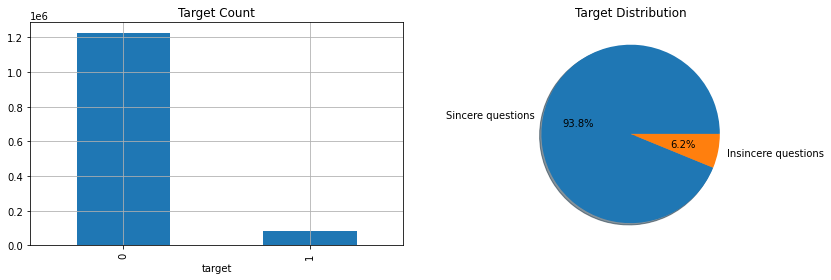

In [ ]:
# Bar chart
plt.subplot(1, 2, 1)
df_train.groupby('target')['qid'].count().plot.bar()
plt.grid(True)
plt.title('Target Count')
plt.subplots_adjust(right=1.9)

# Pie Chart
plt.subplot(1, 2, 2)
values = [df_train[df_train['target']==0].shape[0], df_train[df_train['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Target Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

__Observations:__  
- Data is highly imbalanced with only 6.2% of insincere questions.

#### 2. Word cloud for both sincere and insincere questions

In [ ]:
def display_wordcloud(data, title):
    words_list = data.unique().tolist()
    words = ' '.join(words_list)
    
    wordcloud = WordCloud(width = 800, height = 400,
                      stopwords = set(STOPWORDS)).generate(words)

    plt.figure(figsize=(20, 12), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(f'Words in {title}')
    plt.axis("off")
    plt.show()

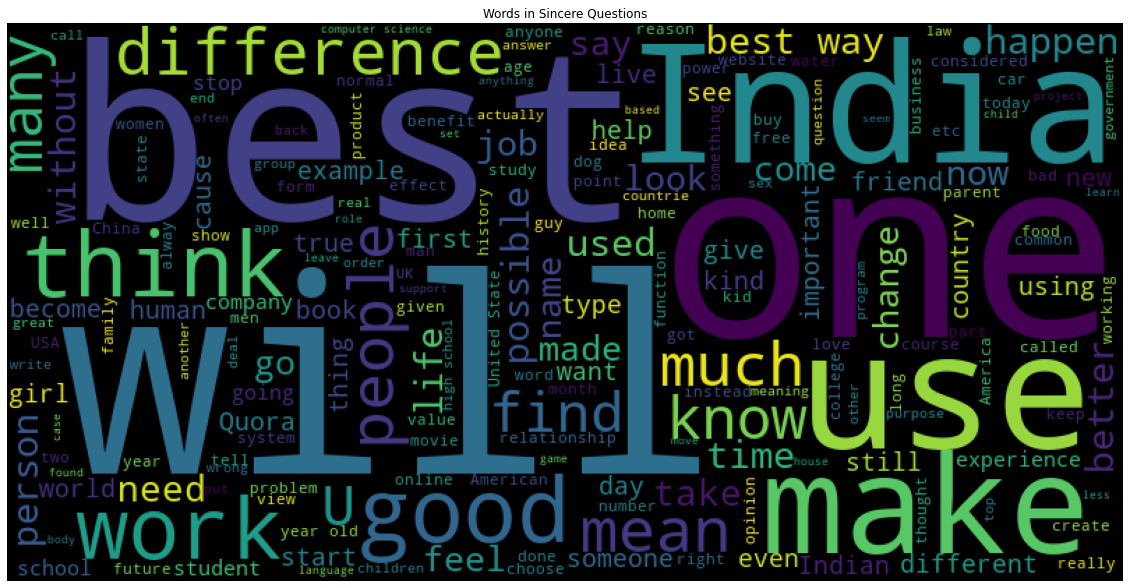

In [ ]:
# Wordcloud for Sincere Questions
display_wordcloud(df_train[df_train['target']==0]['question_text'], 'Sincere Questions')

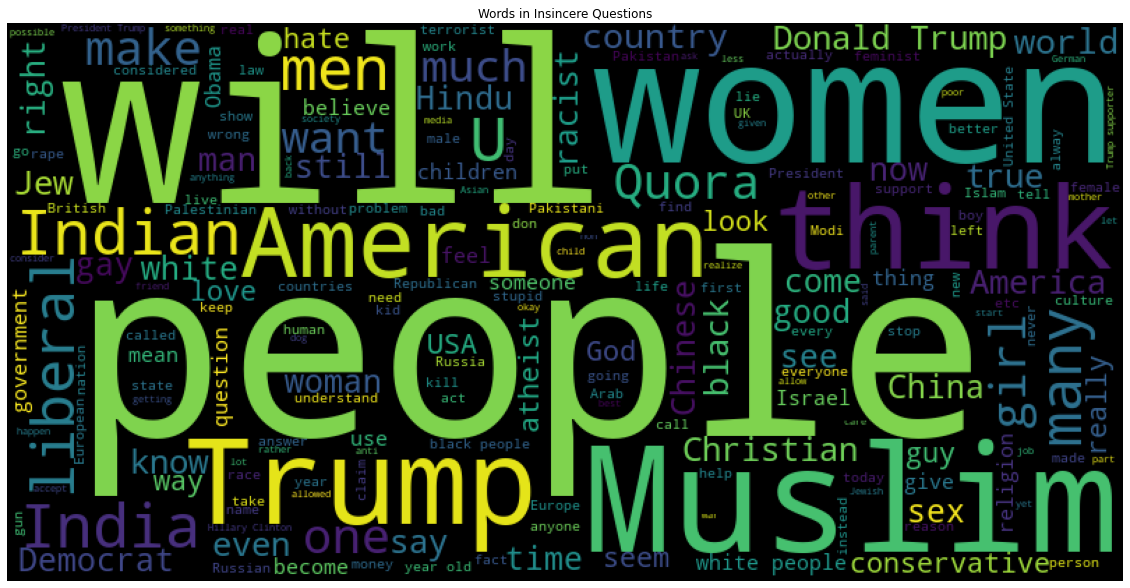

In [ ]:
# Wordcloud for Insincere Questions
display_wordcloud(df_train[df_train['target']==1]['question_text'], 'Insincere Questions')

__Observations:__
- As we can see insincere questions contain many of the offensive words.
- Most of the questions are related to *People*, *Muslim*,  *Women*, *Trump*, etc.

#### 3. Top words in both sincere and insincere questions

In [ ]:
from collections import Counter

def plot_word_freq(data, title, bar_color):
    
  top_words = Counter(data).most_common(25) #top 25 words

  df_top = pd.DataFrame(top_words, columns=['word', 'count']).sort_values('count') # storing in df

  plt.barh(df_top['word'].values, df_top['count'].values, orientation='horizontal', color=bar_color) # plot
  plt.title(f'Top words in {title}')

In [ ]:
def get_unigrams(data):
  unigrams = []
  for sent in data:
    unigrams.extend([w for w in sent.lower().split() if w not in STOPWORDS])
  return unigrams


In [ ]:
# Unigrams
unigrams_sincere  = get_unigrams(df_train[df_train['target']==0]['question_text'])
unigrams_insincere = get_unigrams(df_train[df_train['target']==1]['question_text'])


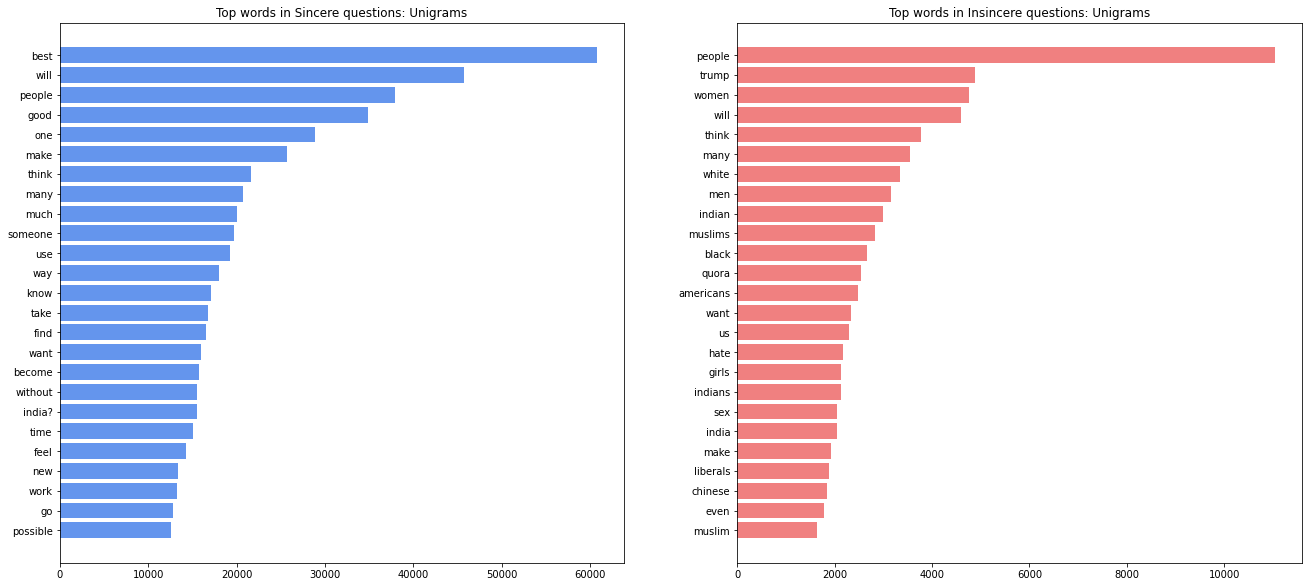

In [ ]:
# Unigrams Sincere words
plt.subplot(1, 2, 1)
plot_word_freq(unigrams_sincere, 'Sincere questions: Unigrams', 'cornflowerblue')

# Unigrams Insincere words
plt.subplot(1, 2, 2)
plot_word_freq(unigrams_insincere, 'Insincere questions: Unigrams', 'lightcoral')
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

#### 4. Basic Feature Extraction

Let's construct few basic features like:
- Number of words
- Number of capital_letters
- Number of special characters
- Number of unique words
- Number of numerics
- Number of characters
- Number of stopwords

In [ ]:

# Number of words
df_train['num_words'] = df_train['question_text'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['question_text'].apply(lambda x: len(str(x).split()))

# Number of capital_letters
df_train['num_capital_let'] = df_train['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
df_test['num_capital_let'] = df_test['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))

# Number of special characters
df_train['num_special_char'] = df_train['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
df_test['num_special_char'] = df_test['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()

# Number of unique words
df_train['num_unique_words'] = df_train['question_text'].apply(lambda x: len(set(str(x).split())))
df_test['num_unique_words'] = df_test['question_text'].apply(lambda x: len(set(str(x).split())))

# Number of numerics
df_train['num_numerics'] = df_train['question_text'].apply(lambda x: sum(c.isdigit() for c in x))
df_test['num_numerics'] = df_test['question_text'].apply(lambda x: sum(c.isdigit() for c in x))

# Number of characters
df_train['num_char'] = df_train['question_text'].apply(lambda x: len(str(x)))
df_test['num_char'] = df_test['question_text'].apply(lambda x: len(str(x)))

# Number of stopwords
df_train['num_stopwords'] = df_train['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))
df_test['num_stopwords'] = df_test['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))

df_train.head()

,qid,question_text,target,num_words,num_capital_let,num_special_char,num_unique_words,num_numerics,num_char,num_stopwords
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4,72,7
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0,81,10
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0,67,3
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0,57,3
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0,77,7


#### 5. Analysis on extracted features.

In [ ]:
print("Minimum length of a question:", min(df_train['num_words']))
print("Maximum length of a question:", max(df_train['num_words']))

Minimum length of a question: 1
Maximum length of a question: 134


In [ ]:
def display_boxplot(_x, _y, _data, _title):
    sns.boxplot(x=_x, y=_y, data=_data)
    plt.grid(True)
    plt.title(_title)

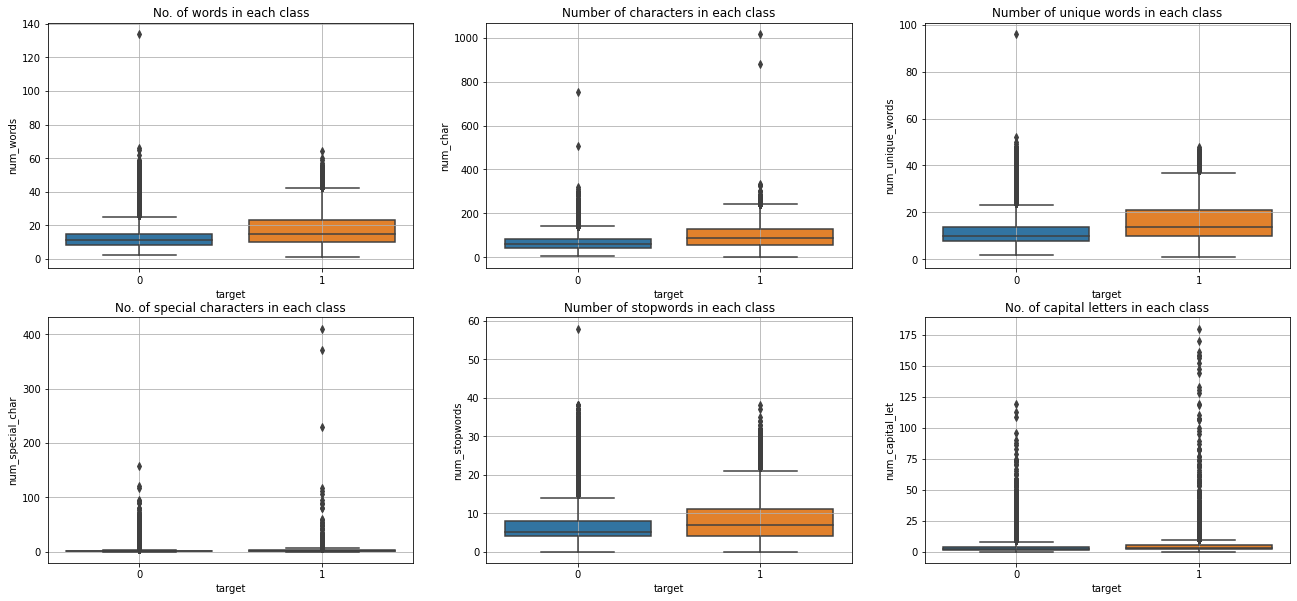

In [ ]:
# Boxplot: Number of words
plt.subplot(2, 3, 1)
display_boxplot('target', 'num_words', df_train, 'No. of words in each class')

# Boxplot: Number of chars
plt.subplot(2, 3, 2)
display_boxplot('target', 'num_char', df_train, 'Number of characters in each class')

# Boxplot: Number of unique words
plt.subplot(2, 3, 3)
display_boxplot('target', 'num_unique_words', df_train, 'Number of unique words in each class')

# Boxplot: Number of special characters
plt.subplot(2, 3, 4)
display_boxplot('target', 'num_special_char', df_train, 'No. of special characters in each class')

# Boxplot: Number of stopwords
plt.subplot(2, 3, 5)
display_boxplot('target', 'num_stopwords', df_train, 'Number of stopwords in each class')

# Boxplot: Number of capital letters
plt.subplot(2, 3, 6)
display_boxplot('target', 'num_capital_let', df_train, 'No. of capital letters in each class')


plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

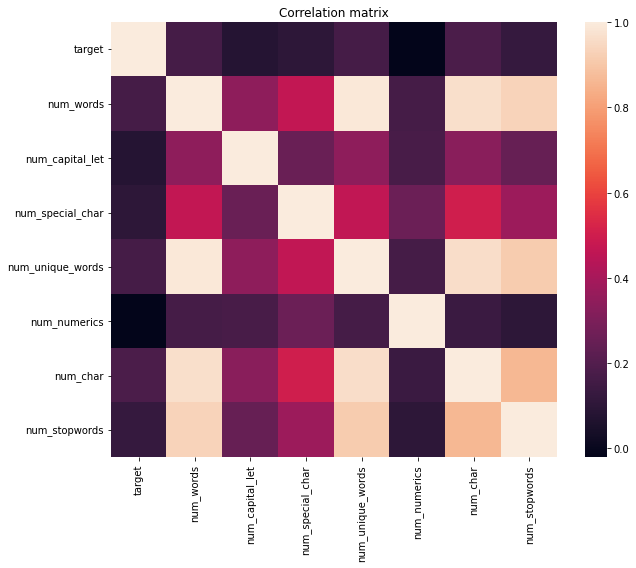

In [ ]:
# Correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = df_train.corr()
sns.heatmap(corr, ax=ax)
plt.title("Correlation matrix")
plt.show()

__Observations__
- Insecure questions seems to have more words and characters.
- Insecure questions also have more unique words compare to sincere questions.

In [ ]:
# Questions with most number of non-alphanumeric characters.
  # Insincere questions are printed in red color.

qids = df_train.sort_values('num_special_char', ascending=False)['qid'].head(20).values
for id in qids:
  row = df_train[df_train['qid'].values == id]
  if row['target'].values[0] == 1: 
    color = '\033[31m'
  else:
    color = '\033[0m'
  print(color, row['question_text'].values[0], '\n')

 What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{\chi=6}^{\infty} \int_{1x^4}^{2x^{-4}} 3x^2 d\vartheta+{2x^{-3}}^{2x^{-5}}}^{3x^{-4}}}} d\m

In [ ]:
def get_all_symbols(data):
  """
  Returns SET: special symbols in corpus
  """
  
  symbols = []
  for text in data:
    s = re.findall(r'\W+', str(text))
    symbols.extend(s), 
  
  return set(symbols)

In [ ]:
extracted_symbols = get_all_symbols(df_train['question_text'].values)
print(extracted_symbols)

{'^ ((', '}} - \\', '": ', '… "?', '/?', '}+', ')} ', ' "…', ') =√ (', '\\, ', '→ ', ' )-\\', ' << & >>?', ')’, ', '": "----\\"><', ')(', '/? ', ') ≤ ', '**** ', ' "§" ', '?""', '”, ', ' ]?', ' -" ', 'ে ', '-" ', ') % ', ']{{{{\\', ",'", ' = ∡', ' )', ']"? ', ') |', ' ∩ ', ' (>', '= [(', '." - ', ');}', '/"), ', " '& ", '}[', '+ {', ' "\'', '/√', ' = -', ' = \\', '" ? ', "' . ", '!"', '} $\\', '%…?', " '?", '<<', ' "-" ', ')}] ', '}) = \\', '} + (', '} +\\ {', ' ¡ ', '}) ^ ', '-\\', ' >= ', ') <', '.): ', ') ∨(', ' - $', 'ْ', ')=\\', ' "."?', ') <= ', '{\\', '*)', '!}) [/', ']-√', ' - √', ' () () ', '} )[/', '}}{-', ']((', ' #$! & ', "' \\\\ ", ' ⊆ ', '} \\$$?', ' / "', '*(-', ' ://', '?”, “', ') {', ' (+', '\u200f?', '+…; ', '...) ^', ') -(-', '?”)', ') = -', ' ``', '=?', ' √ [(', ')] ', '$/', ' *?', ')) +… (', '़ि ', '%", ', '+(-', ' ≥ ', '] ', '"+', '¿?', '" [', ' $)? ', ' = - \\', ' ==$', " = '", '--, ++', '°. ', ' (‘', '? \xad?', ' (<$', '\u2060\u2060', ' .. ', '%); ', ' ÷', ', …,

__Observations:__
- Looks like there are some math questions(most of them are classified as insincere) in the data which contains more special chars and numbers.
- Some questions also contains emojis and non-english characters.
- Presence of punctuations in may add more value to ML models.

#Data Preprocessing & Cleaning 

We have 2 datasets with us, one is imbalance and other one is balance both are need to clean.

**1) Lower Casing**

In [ ]:
df_train["question_text"] = df_train["question_text"].str.lower()
df_app["question_text"] = df_app["question_text"].str.lower()
df_app.head()

,qid,question_text,target,ï»¿qid
0,00002165364db923c7e6,how did quebec nationalists see their province...,0,NaN
1,000032939017120e6e44,"do you have an adopted dog, how would you enco...",0,NaN
2,0000412ca6e4628ce2cf,why does velocity affect time? does velocity a...,0,NaN
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0,NaN
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0,NaN


**2) Contractions**

In [ ]:
! pip install contractions
import contractions
df_train["question_text"] = df_train["question_text"].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_app["question_text"] = df_app["question_text"].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_train.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.6 MB/s 
     |████████████████████████████████| 287 kB 24.3 MB/s 


,qid,question_text,target,num_words,num_capital_let,num_special_char,num_unique_words,num_numerics,num_char,num_stopwords
0,00002165364db923c7e6,"[how, did, quebec, nationalists, see, their, p...",0,13,2,1,13,4,72,7
1,000032939017120e6e44,"[do, you, have, an, adopted, dog,, how, would,...",0,16,1,2,15,0,81,10
2,0000412ca6e4628ce2cf,"[why, does, velocity, affect, time?, does, vel...",0,10,2,2,8,0,67,3
3,000042bf85aa498cd78e,"[how, did, otto, von, guericke, used, the, mag...",0,9,4,1,9,0,57,3
4,0000455dfa3e01eae3af,"[can, i, convert, montra, helicon, d, to, a, m...",0,15,3,1,15,0,77,7


In [ ]:
df_train['question_text'] = [' '.join(map(str, l)) for l in df_train['question_text']]
df_app['question_text'] = [' '.join(map(str, l)) for l in df_app['question_text']]
df_train.head()

**3) Removal of Stopwords**

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_train["question_text"] = df_train["question_text"].apply(lambda text: remove_stopwords(text))
df_app["question_text"] = df_app["question_text"].apply(lambda text: remove_stopwords(text))
df_train.head()

**4)Remove Integers from the Text.**

In [41]:
df_train['question_text'] = df_train['question_text'].str.replace('\d+', '')
df_app['question_text'] = df_app['question_text'].str.replace('\d+', '')
df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,qid,question_text,target,num_words,num_capital_let,num_special_char,num_unique_words,num_numerics,num_char,num_stopwords
0,00002165364db923c7e6,quebec nationalists see province nation s?,0,13,2,1,13,4,72,7
1,000032939017120e6e44,"adopted dog, would encourage people adopt shop?",0,16,1,2,15,0,81,10
2,0000412ca6e4628ce2cf,velocity affect time? velocity affect space ge...,0,10,2,2,8,0,67,3
3,000042bf85aa498cd78e,otto von guericke used magdeburg hemispheres?,0,9,4,1,9,0,57,3
4,0000455dfa3e01eae3af,convert montra helicon mountain bike changing ...,0,15,3,1,15,0,77,7


**5)Stemming**

In [ ]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df_train["question_text"] = df_train["question_text"].apply(lambda text: stem_words(text))
df_app["question_text"] = df_app["question_text"].apply(lambda text: stem_words(text))
df_train.head()

**6)Lemmatization**

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df_train["question_text"] = df_train["question_text"].apply(lambda text: lemmatize_words(text))
df_app["question_text"] = df_app["question_text"].apply(lambda text: lemmatize_words(text))
df_train.head()

**7)Remove URL from the texts**

In [ ]:
df_train["question_text"] = df_train["question_text"].str.replace(r's*https?://S+(s+|$)', ' ').str.strip()
df_app["question_text"] = df_app["question_text"].str.replace(r's*https?://S+(s+|$)', ' ').str.strip()

**8)Remove HTML Tags**

In [ ]:
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
df_train['preprocessed_question_text']= df_train['question_text'].apply(lambda cw : remove_tags(cw))
df_app['preprocessed_question_text']= df_app['question_text'].apply(lambda cw : remove_tags(cw))
df_train.head()

# Modeling

In [ ]:
#Libraries used for modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

####Firstly, fitting model using Imabalce data and will see the acuracy.

1) Multinomial Naive-Bayes Classifier

2) Logistic Regression

Splitting Train-Test Data

In [ ]:
X = df_train['preprocessed_question_text']
Y = df_train['target']

In [ ]:
#Suffling the data and splitting the data into train and test sets (75:25)

X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state = 2000, shuffle= True)

###**Multinomial Naive- Bayes Classifier**

In [ ]:
pipeline=Pipeline([('bow',CountVectorizer(dtype=np.float32,
                                          strip_accents='unicode',
                                          analyzer='word',
                                          token_pattern=r'\w{1,}',
                                          ngram_range=(1,3),
                                          min_df=3)), #Minimum Document Frequency
                   ('tfidf',TfidfTransformer()),
                   ('classifier',MultinomialNB())
                   ])

In [ ]:
pipeline.fit(X_train, Y_train)
pred=pipeline.predict(X_test)

In [ ]:
print('Test Accuracy using MultiNomial Naive Bayes Classifier: ',accuracy_score(Y_test,pred))

In [ ]:
print(classification_report(Y_test,pred))

In [ ]:
print(confusion_matrix(Y_test, pred))
cm_nb = confusion_matrix(Y_test, pred)

fig, ax = plot_confusion_matrix(conf_mat=cm_nb , figsize=(5, 5))
plt.show()

In [ ]:
y_pred_proba = pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)

In [ ]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(f"Correctly classified sincere questions: {round(cm_nb[0][0]/(cm_nb[0][0] + cm_nb[0][1])*100, 2)}%")
print(f"Correctly classified insincere questions: {round(cm_nb[1][1]/(cm_nb[1][0] + cm_nb[1][1])*100, 2)}%")

### **While the classifier has a high accuracy, it fails to classify  even a single example from the minority class **

###**Logistic Regression**

In [ ]:
pipeline2 =Pipeline([('bow',CountVectorizer(dtype=np.float32,
                                          strip_accents='unicode',
                                          analyzer='word',
                                          token_pattern=r'\w{1,}',
                                          ngram_range=(1,3),
                                          min_df=3)),
                   ('tfidf',TfidfTransformer()),
                   ('classifier',LogisticRegression())
                   ])

In [ ]:
pipeline2.fit(X_train, Y_train)
pred2=pipeline2.predict(X_test)

In [ ]:
print('Test Accuracy using Logistics Regression Classifier: ',accuracy_score(Y_test,pred2))

In [ ]:
print(classification_report(Y_test,pred2))

In [ ]:
print(confusion_matrix(Y_test, pred2))
cm_lr = confusion_matrix(Y_test, pred2)

fig, ax = plot_confusion_matrix(conf_mat=cm_lr ,  figsize=(5, 5))
plt.show()

In [ ]:
y_pred_proba2 = pipeline2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba2)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(f"Correctly classified sincere questions: {round(cm_lr[0][0]/(cm_lr[0][0] + cm_lr[0][1])*100, 2)}%")
print(f"Correctly classified insincere questions: {round(cm_lr[1][1]/(cm_lr[1][0] + cm_lr[1][1])*100, 2)}%")

### **Same as here also, While the classifier has a high accuracy, it fails to classify even a single example from the minority class** 

#Text Over Sampling 

In [ ]:
# Class count
count_target_0, count_target_1 = df_train.target.value_counts()

# Divide by class
df_train_0 = df_train[df_train['target'] == 0]
df_train_1 = df_train[df_train['target'] == 1]

In [ ]:
# Oversample 1-class and concat the DataFrames of both classes
df_train_1_over = df_train_1.sample(count_target_0, replace=True)
df_test_over = pd.concat([df_train_0, df_train_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

In [ ]:
df_test_over.head()

In [ ]:
df_test_over.shape

In [ ]:
x = df_test_over['preprocessed_question_text']
y = df_test_over['target']

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=15)

In [ ]:
pipeline3=Pipeline([('bow',CountVectorizer(dtype=np.float32,
                                         strip_accents='unicode',
                                        analyzer='word',
                                       token_pattern=r'\w{1,}',
                                      ngram_range=(1,3),
                                     min_df=3)),
            ('tfidf',TfidfTransformer()),
             ('classifier',LogisticRegression())
            ])

In [ ]:
pipeline3.fit(xtrain, ytrain)
pred=pipeline3.predict(xtest)

print('Test Accuracy using Logistics Regression Classifier: ',accuracy_score(ytest,pred))


print(classification_report(ytest,pred))

print(confusion_matrix(ytest, pred))
CM = confusion_matrix(ytest, pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
y_pred_proba_os = pipeline3.predict_proba(xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba_os)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

__It has over sample the minority data with equal number of majority.__

__It is over fitting the data.__

#Good Model

__Copy paste the minority data by 7 times in Excel sheet and merged with train data.__

__Using append function we add this data.__

I will use this **append **dataset for further predictions.

In [ ]:
df_app['target'].value_counts()

## There are two methods of Vectorizerzation 

1) TfidfVectorizer

2) CountVectorizer

We will use only **TfidfVectorizer**.

**## TfidfVectorizer**

In [ ]:
X = df_app['preprocessed_question_text']
Y = df_app['target']

In [ ]:
Xtrain, Xtest, Ytrain, Ytest= train_test_split(X, Y, test_size=0.25, random_state= 2000, shuffle= True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfv = TfidfVectorizer(dtype=np.float32, min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
xv_train = tfv.fit_transform(Xtrain)
xv_test = tfv.transform(Xtest)

In [ ]:
print("Number of data points in train data :",xv_train.shape, Ytrain.shape)
print("Number of data points in test data :",xv_test.shape, Ytest.shape)

In [ ]:
df_app.head()

In [ ]:
df_app = df_app.drop(['qid', 'question_text', 'ï»¿qid'], axis=1, inplace=True)

##**Logistic Regression**

In [ ]:
LR = LogisticRegression()
LR.fit(xv_train,Ytrain)

In [ ]:
#Predition
pred_lr=LR.predict(xv_test)

In [ ]:
print('Test Accuracy using Logistics Regression Classifier: ',accuracy_score(Ytest,pred_lr))

In [ ]:
print(classification_report(Ytest,pred_lr))

In [ ]:
print(confusion_matrix(Ytest,pred_lr))
CM_lr = confusion_matrix(Ytest,pred_lr)

fig, ax = plot_confusion_matrix(conf_mat=CM_lr ,  figsize=(5, 5)) #Plotting Confusion Matrix using Heatmap
plt.show()

In [ ]:
y_pred_proba_LR = LR.predict_proba(xv_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Ytest,  y_pred_proba_LR)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(f"Correctly classified sincere questions: {round(CM_lr[0][0]/(CM_lr[0][0] + CM_lr[0][1])*100, 2)}%")
print(f"Correctly classified insincere questions: {round(CM_lr[1][1]/(CM_lr[1][0] + CM_lr[1][1])*100, 2)}%")

This Logistic Regression model is correctly classifying the both sincere and insincere questions.

##**Multinomial-Naive Bayes Classifier** 

In [ ]:
NB = MultinomialNB()
NB.fit(xv_train, Ytrain)

In [ ]:
#Predition
pred_nb=NB.predict(xv_test)

In [ ]:
print('Test Accuracy using Multinomial Naive-Bayes Classifier: ',accuracy_score(Ytest,pred_nb))

In [ ]:
print(classification_report(Ytest,pred_nb))

print(confusion_matrix(Ytest,pred_nb))

In [ ]:
print(confusion_matrix(Ytest,pred_nb))
CM_nb = confusion_matrix(Ytest,pred_nb)

fig, ax = plot_confusion_matrix(conf_mat=CM_nb ,  figsize=(5, 5)) #Plotting Confusion Matrix using Heatmap
plt.show()

In [ ]:
y_pred_proba_NB = NB.predict_proba(xv_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Ytest,  y_pred_proba_NB)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(f"Correctly classified sincere questions: {round(CM_nb[0][0]/(CM_nb[0][0] + CM_nb[0][1])*100, 2)}%")
print(f"Correctly classified insincere questions: {round(CM_nb[1][1]/(CM_nb[1][0] + CM_nb[1][1])*100, 2)}%")

This Naive- Bayes model is also correctly classifying the both sincere and insincere questions with good accuracy.

After model building some Sincere and Insisncere words.

In [ ]:
!pip install regex eli5 emoji
import eli5

In [ ]:
eli5.show_weights(LR, vec=tfv, top=50, feature_filter=lambda x:x != '<BIAS>')

#Prediction System

In [ ]:
def output_lable(n):
    if n == 0:
        return "Yes!! This question is Sincere :)"
    elif n == 1:
        return "This Question Looks like an Insincere :("
    
def manual_testing(question):
    testing_question = {"text":[question]}
    new_def_test = pd.DataFrame(testing_question)
    new_x_test = new_def_test["text"]
    new_xv_test = tfv.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)
    pred_NB = NB.predict(new_xv_test)

    return print("LR Prediction:{} \nNB Prediction: {}".format(output_lable(pred_LR[0]),
                                                               output_lable(pred_NB[0])))

In [ ]:
question = str(input())
manual_testing(question)

 # Deployment 

**Saving Trained Model**

In [ ]:
import pickle

In [ ]:
filename = 'trained_model1.sav'
pickle.dump(NB, open(filename, 'wb'))

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('trained_model1.sav', 'rb'))

In [ ]:
def output_lable(n):
    if n == 0:
        return "Yes!! This question is Sincere :)"
    elif n == 1:
        return "This Question Looks like an Insincere :("
    
def manual_testing(question):
    testing_news = {"text":[question]}
    new_def_test = pd.DataFrame(testing_news)
    new_x_test = new_def_test["text"]
    new_xv_test = tfv.transform(new_x_test)
    pred_LR = loaded_model.predict(new_xv_test)

    return print("LR Prediction:",(output_lable(pred_NB[0])))

In [ ]:
question = str(input())
manual_testing(question)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=2000, shuffle=True)

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipe_nb = Pipeline(steps=[('bow', TfidfVectorizer()), ('nb', MultinomialNB())])

In [ ]:
pipe_nb.fit(xtrain, ytrain)

In [ ]:
pipe_nb.score(xtest, ytest)

Prediction

In [ ]:
#Prediction
ques = "Please, Enter your question"

In [ ]:
pipe_nb.predict([ques])

In [ ]:
pipe_nb.classes_

In [ ]:
#save model and Pipeline
import joblib
pipeline_file = open("question_model.pkl", "wb")
joblib.dump(pipe_nb, pipeline_file)
pipeline_file.close()

#**Thank You !!** 😃